In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### Image data in colab

In [2]:
!unzip "/content/drive/MyDrive/Datasets/xray_data.zip"

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

### Importing Libraries

In [3]:
%pwd

'/content'

In [4]:
data_dir = "/content/chest_xray"

In [43]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Conv2D,Activation, MaxPooling2D,Dense,Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf

tf.__version__

'2.14.0'

In [6]:
train_data_dir = f'{data_dir}/train/'
batch_size = 32

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_iterator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    classes =('PNEUMONIA','NORMAL'),
    batch_size=batch_size,
    subset='training') # set as training data

valid_iterator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(224, 224),
    batch_size=batch_size,
    classes =('PNEUMONIA','NORMAL'),
    subset='validation')

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [8]:
# # prepare iterators
# train_iterator = train_datagen.flow_from_directory(f'{data_dir}/train/',classes =('PNEUMONIA','NORMAL'),batch_size=batch_size, target_size=(224, 224))
# valid_iterator = valid_datagen.flow_from_directory(f'{data_dir}/test/',classes =('PNEUMONIA','NORMAL'),batch_size=batch_size, target_size=(224, 224))

### Base Model (Conv2D, ReLU, Maxpooling units)

In [87]:
# set random seed for some reproducibility
tf.random.set_seed(42)

# create the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=(224, 224, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1000),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Dense(2, activation="sigmoid")
])

# view model architecture
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 activation_21 (Activation)  (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 activation_22 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 56, 56, 64)        0         
 ng2D)                                                

In [88]:
# compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=['accuracy'])

In [89]:
callbacks = [ModelCheckpoint('medical_diagnosis_cnn_model.hdf5', verbose=1, save_best_only=True)]

In [90]:
epochs=20
history = model.fit(train_iterator,
                    steps_per_epoch=len(train_iterator)/batch_size,
                    validation_data=valid_iterator,
                    validation_steps=len(valid_iterator)/batch_size,
                    callbacks=callbacks,
                    epochs=epochs,
                    verbose=1)

Epoch 1/20
5/4 [====================================] - ETA: 0s - loss: 0.6751 - accuracy: 0.6500
Epoch 1: val_loss improved from inf to 0.64070, saving model to medical_diagnosis_cnn_model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 14s 4s/step - loss: 0.6751 - accuracy: 0.6500 - val_loss: 0.6407 - val_accuracy: 0.7500
Epoch 2/20
5/4 [====================================] - ETA: 0s - loss: 0.6486 - accuracy: 0.7000
Epoch 2: val_loss improved from 0.64070 to 0.63604, saving model to medical_diagnosis_cnn_model.hdf5
4/4 [==============================] - 15s 5s/step - loss: 0.6486 - accuracy: 0.7000 - val_loss: 0.6360 - val_accuracy: 0.7031
Epoch 3/20
5/4 [====================================] - ETA: 0s - loss: 0.5840 - accuracy: 0.8125
Epoch 3: val_loss improved from 0.63604 to 0.61506, saving model to medical_diagnosis_cnn_model.hdf5
4/4 [==============================] - 13s 4s/step - loss: 0.5840 - accuracy: 0.8125 - val_loss: 0.6151 - val_accuracy: 0.7031
Epoch 4/20
5/4 [====================================] - ETA: 0s - loss: 0.6012 - accuracy: 0.7375
Epoch 4: val_loss improved from 0.61506 to 0.58638, saving model to medical_diagnosis_cnn_model.hdf5
4/4 [=================

In [91]:
# save model
# model.save('medical_diagnosis_cnn_model.h5')

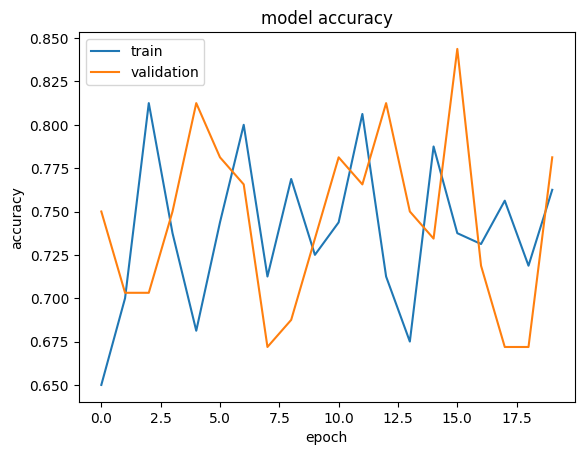

In [92]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

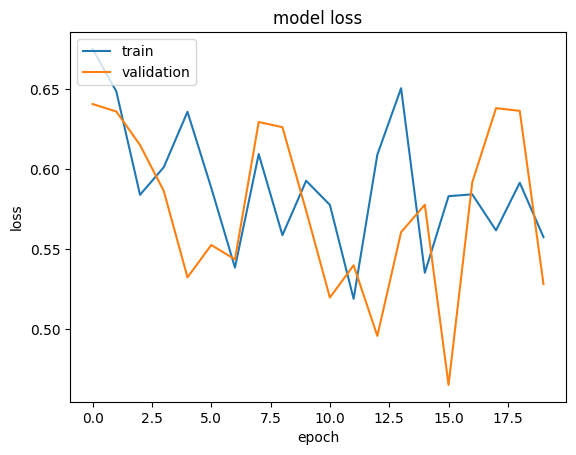

In [93]:
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [94]:
# load test data
batch_size=32
test_datagen = ImageDataGenerator(rescale=1.0/255.0,)

test_it = test_datagen.flow_from_directory(f'/content/chest_xray/test',classes =('NORMAL','PNUEMONIA'),
                                            shuffle=False,batch_size=batch_size, target_size=(224, 224))

Found 234 images belonging to 2 classes.


In [95]:
y_true = test_it.classes;
y_pred = model.predict(test_it, steps=len(test_it), verbose=1)

8/8 [==============================] - 3s 315ms/step


In [96]:
y_pred_prob = y_pred[:,1]
y_pred_binary =  np.where(y_pred_prob > 0.5, 1, 0)

In [97]:
y_true[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [98]:
y_pred_binary[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [99]:
model.evaluate(test_it)

8/8 [==============================] - 3s 317ms/step - loss: 0.3117 - accuracy: 1.0000


[0.3116765022277832, 1.0]

### Deeper Model Architecture

In [100]:
# set random seed for some reproducibility
tf.random.set_seed(42)

# create the model
model = tf.keras.Sequential()

#  First Block of CNN
model.add(Conv2D(8, (5, 5), padding='same', input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

#  Second Block of CNN
model.add(Conv2D(8, (3, 3),  padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

#  Third Block of CNN
model.add(Conv2D(16, (3, 3),  padding='same'))
model.add(Activation('relu'))


#  Forth Block of CNN
model.add(Conv2D(16, (3, 3),  padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))


#  Flatten and Fully Connected Layer
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('relu'))

#  Softmax Classifier
model.add(Dense(2))
model.add(Activation('sigmoid'))

# view model architecture
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 224, 224, 8)       608       
                                                                 
 activation_25 (Activation)  (None, 224, 224, 8)       0         
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 112, 112, 8)       0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 112, 112, 8)       584       
                                                                 
 activation_26 (Activation)  (None, 112, 112, 8)       0         
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 56, 56, 8)         0         
 ng2D)                                                

In [101]:
# compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])

In [102]:
callbacks = [ModelCheckpoint('medical_diagnosis_cnn_model_deeper.hdf5', verbose=1, save_best_only=True)]

In [103]:
epochs=10
history = model.fit(train_iterator,
                    steps_per_epoch=len(train_iterator)/batch_size,
                    validation_data=valid_iterator,
                    validation_steps=len(valid_iterator)/batch_size,
                    callbacks=callbacks,
                    epochs=epochs,
                    verbose=1)

Epoch 1/10
5/4 [====================================] - ETA: 0s - loss: 0.6186 - accuracy: 0.6454
Epoch 1: val_loss improved from inf to 0.60931, saving model to medical_diagnosis_cnn_model_deeper.hdf5
4/4 [==============================] - 10s 2s/step - loss: 0.6186 - accuracy: 0.6454 - val_loss: 0.6093 - val_accuracy: 0.7031
Epoch 2/10
5/4 [====================================] - ETA: 0s - loss: 0.5876 - accuracy: 0.7376
Epoch 2: val_loss improved from 0.60931 to 0.51851, saving model to medical_diagnosis_cnn_model_deeper.hdf5
4/4 [==============================] - 6s 2s/step - loss: 0.5876 - accuracy: 0.7376 - val_loss: 0.5185 - val_accuracy: 0.7812
Epoch 3/10
5/4 [====================================] - ETA: 0s - loss: 0.5656 - accuracy: 0.7500
Epoch 3: val_loss did not improve from 0.51851
4/4 [==============================] - 10s 3s/step - loss: 0.5656 - accuracy: 0.7500 - val_loss: 0.5712 - val_accuracy: 0.7188
Epoch 4/10
5/4 [====================================] - ETA: 0s - l

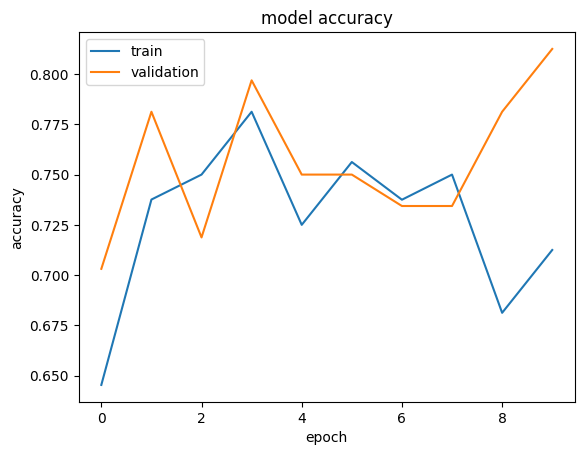

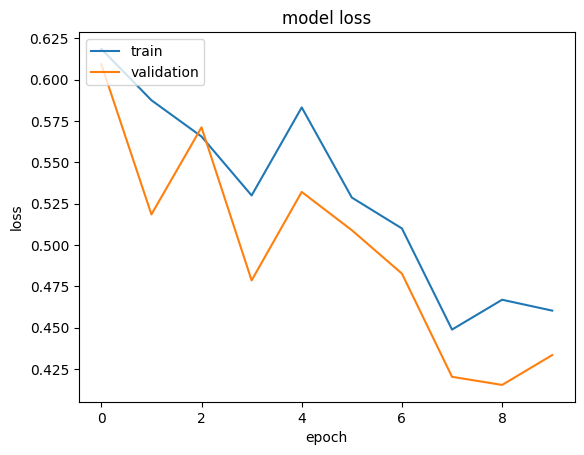

In [104]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [105]:
# load test data
batch_size=32
test_datagen = ImageDataGenerator(rescale=1.0/255.0,)

test_it = test_datagen.flow_from_directory(f'/content/chest_xray/test',classes =('NORMAL','PNUEMONIA'),
                                            shuffle=False,batch_size=batch_size, target_size=(224, 224))

Found 234 images belonging to 2 classes.


In [106]:
y_true = test_it.classes;
y_pred = model.predict(test_it, steps=len(test_it), verbose=1)

8/8 [==============================] - 4s 441ms/step


In [107]:
model.evaluate(test_it)

8/8 [==============================] - 3s 301ms/step - loss: 0.6296 - accuracy: 1.0000


[0.6296283602714539, 1.0]

### With Batch Normalization

In [108]:
# set random seed for some reproducibility
tf.random.set_seed(42)

# create the model
model = tf.keras.Sequential()

#  First Block of CNN
model.add(Conv2D(8, (5, 5), padding='same', input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

#  Second Block of CNN
model.add(Conv2D(8, (3, 3),  padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

#  Third Block of CNN
model.add(Conv2D(16, (3, 3),  padding='same'))
model.add(Activation('relu'))


#  Forth Block of CNN
model.add(Conv2D(16, (3, 3),  padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))


#  Flatten and Fully Connected Layer
model.add(Flatten())
model.add(Dense(10))
model.add(tf.keras.layers.BatchNormalization())
model.add(Activation('relu'))

#  Softmax Classifier
model.add(Dense(2))
model.add(Activation('sigmoid'))

# view model architecture
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 224, 224, 8)       608       
                                                                 
 activation_31 (Activation)  (None, 224, 224, 8)       0         
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 112, 112, 8)       0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 112, 112, 8)       584       
                                                                 
 activation_32 (Activation)  (None, 112, 112, 8)       0         
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 56, 56, 8)         0         
 ng2D)                                                

In [109]:
# compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])

In [110]:
callbacks = [ModelCheckpoint('medical_diagnosis_cnn_model_bn.hdf5', verbose=1, save_best_only=True)]

In [111]:
epochs=10
history = model.fit(train_iterator,
                    steps_per_epoch=len(train_iterator)/batch_size,
                    validation_data=valid_iterator,
                    validation_steps=len(valid_iterator)/batch_size,
                    callbacks=callbacks,
                    epochs=epochs,
                    verbose=1)

Epoch 1/10
5/4 [====================================] - ETA: 0s - loss: 0.6609 - accuracy: 0.6812
Epoch 1: val_loss improved from inf to 0.73298, saving model to medical_diagnosis_cnn_model_bn.hdf5
4/4 [==============================] - 13s 3s/step - loss: 0.6609 - accuracy: 0.6812 - val_loss: 0.7330 - val_accuracy: 0.1719
Epoch 2/10
5/4 [====================================] - ETA: 0s - loss: 0.5633 - accuracy: 0.7937
Epoch 2: val_loss improved from 0.73298 to 0.72159, saving model to medical_diagnosis_cnn_model_bn.hdf5
4/4 [==============================] - 8s 2s/step - loss: 0.5633 - accuracy: 0.7937 - val_loss: 0.7216 - val_accuracy: 0.2344
Epoch 3/10
5/4 [====================================] - ETA: 0s - loss: 0.5249 - accuracy: 0.8375
Epoch 3: val_loss improved from 0.72159 to 0.69634, saving model to medical_diagnosis_cnn_model_bn.hdf5
4/4 [==============================] - 6s 2s/step - loss: 0.5249 - accuracy: 0.8375 - val_loss: 0.6963 - val_accuracy: 0.3750
Epoch 4/10
5/4 [===

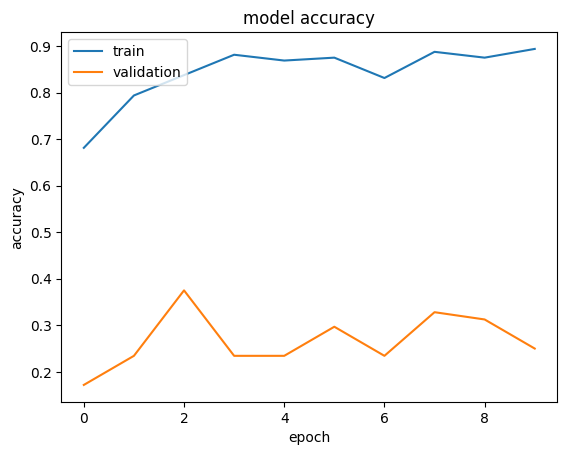

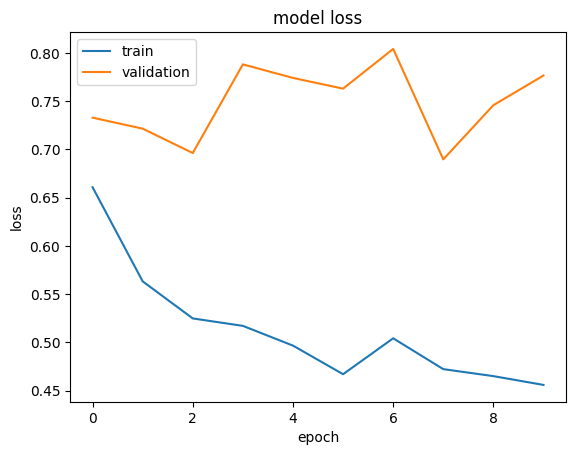

In [112]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy'),

plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [113]:
# load test data
batch_size=32
test_datagen = ImageDataGenerator(rescale=1.0/255.0,)

test_it = test_datagen.flow_from_directory(f'/content/chest_xray/test',classes =('NORMAL','PNUEMONIA'),
                                            shuffle=False,batch_size=batch_size, target_size=(224, 224))

Found 234 images belonging to 2 classes.


In [114]:
y_true = test_it.classes;
y_pred = model.predict(test_it, steps=len(test_it), verbose=1)

8/8 [==============================] - 3s 294ms/step


### Transfer learning with ResNet

In [115]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model

In [116]:
ResNet = ResNet50(include_top=True, input_shape=(224, 224, 3))

# mark loaded layers as not trainable
for layer in ResNet.layers:
  layer.trainable = False

# mark loaded layers as trainable
# for layer in ResNet.layers[100:]:
#   layer.trainable = True

#  Softmax Classifier
class_layer = Dense(2)(ResNet.layers[-2].output)

sigmoid_layer = Activation('sigmoid')(class_layer)

# define new model
model = Model(inputs=ResNet.inputs, outputs=sigmoid_layer)

#  Display model
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_6[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [117]:
# compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [121]:
epochs=4
history = model.fit(train_iterator,
                    steps_per_epoch=len(train_iterator)/batch_size,
                    validation_data=valid_iterator,
                    validation_steps=len(valid_iterator)/batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/4
4/4 [==============================] - 9s 3s/step - loss: 0.5829 - accuracy: 0.7375 - val_loss: 0.6139 - val_accuracy: 0.7031
Epoch 2/4
4/4 [==============================] - 6s 2s/step - loss: 0.5817 - accuracy: 0.7437 - val_loss: 0.5628 - val_accuracy: 0.7656
Epoch 3/4
4/4 [==============================] - 10s 3s/step - loss: 0.5989 - accuracy: 0.7188 - val_loss: 0.5706 - val_accuracy: 0.7500
Epoch 4/4
4/4 [==============================] - 6s 2s/step - loss: 0.5575 - accuracy: 0.7625 - val_loss: 0.5312 - val_accuracy: 0.7812


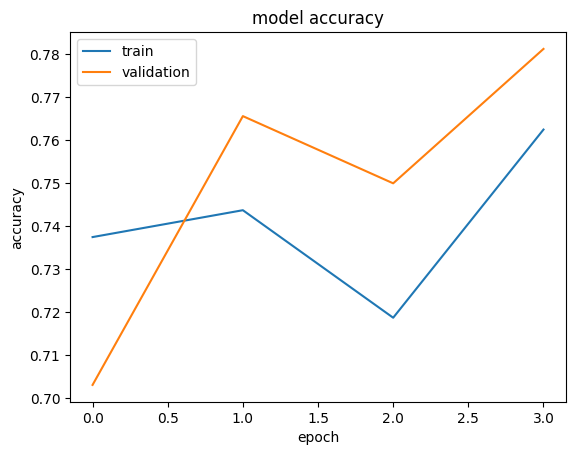

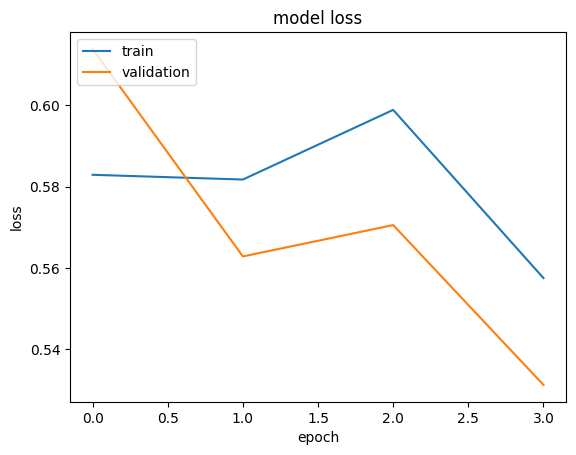

In [122]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()